In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage
import io
import xarray as xr
import pickle

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [3]:
fshear = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors.p', "rb"))
ftcw = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors.p', "rb"))

shearfac = fshear['obs_shear'] #0.71 # monthly: 0.55
tcwvfac =  np.mean(ftcw['relmm']) #3.11 # relative change
tcabsfac = np.mean(ftcw['abs']) #1.21 # absolute change

tcabserr = np.std(ftcw['abs']) #0.06 #mm h
tcrelerr = np.std(ftcw['relmm']) #0.18 #%
mmPerPercent = tcabsfac/tcwvfac

errperperc = tcabserr / tcrelerr

In [4]:
print(fshear.keys())
print(ftcw.keys())

dict_keys(['obs_shear', 'cp4_shear'])
dict_keys(['rel', 'abs'])


In [5]:
errperperc

0.06277150316946438

In [6]:
mmPerPercent

0.40169146896702357

In [7]:
tcrelerr

0.20835269605453657

In [8]:
tcabserr

0.013078611920753791

In [9]:
base = '/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/'

dics = ['CP4hist', 'CP4fut', 'CP25hist', 'CP25fut']
cp4_read = {'period' : [], 'shear' : [], 'tcwv' : []}
for dd in dics:
   
    dic = pd.read_csv(base+dd+'_vars_DAILY.csv', index_col=0)
    #ipdb.set_trace()
    cp4_read['period'].append(dd)
    cp4_read['shear'].append(np.array(dic.loc['shear'])*-1)
    cp4_read['tcwv'].append(np.array(dic.loc['tcwv']))


In [10]:
cp4_read

{'period': ['CP4hist', 'CP4fut', 'CP25hist', 'CP25fut'],
 'shear': [array([13.122973]),
  array([16.145008]),
  array([12.626462]),
  array([14.523413])],
 'tcwv': [array([37.21887]),
  array([57.760437]),
  array([37.291157]),
  array([58.429615])]}

In [11]:
cp4_df = pd.DataFrame.from_dict(cp4_read)
cp4_df = cp4_df.set_index('period')

In [12]:
cp4_df.loc['CP4fut','shear']

array([16.145008])

In [13]:
cp4_shear_diff = cp4_df.loc['CP4fut', 'shear']-cp4_df.loc['CP4hist', 'shear']
cp25_shear_diff = cp4_df.loc['CP25fut', 'shear']-cp4_df.loc['CP25hist', 'shear']

cp4_tcwv_diff = cp4_df.loc['CP4fut', 'tcwv']-cp4_df.loc['CP4hist', 'tcwv']
cp25_tcwv_diff = cp4_df.loc['CP25fut', 'tcwv']-cp4_df.loc['CP25hist', 'tcwv']

In [14]:
cp4 = '/home/ck/DIR/cornkle/figs/ENDGAME/lawrence/textfiles/impala_jas_mean_metrics_v02.txt'

In [15]:
base = '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/'
dics = [('2020-2050', '2030'), ('2030-2060', '2040'), ('2050-2080', '2060'), ('2070-2100', '2080')]
cmip_read = {}
for dd in dics:
    cmip_read[dd[1]] = pd.read_csv(base+dd[0]+'_CMIP.csv', index_col='model_name')
#     (cmip_read[dd[1]])['shear_mean_precip'] = (cmip_read[dd[1]])['shear_mean'] 
#     (cmip_read[dd[1]])['tcw_mean_precip'] = (cmip_read[dd[1]])['tcwv_mean'] 
#     (cmip_read[dd[1]])['shear_perc_'] = (cmip_read[dd[1]])['tcwv_mean'] 

In [16]:
cmip_read['2040']

,Unnamed: 0,shear_mean,tcw_mean,tcw_hist,shear_hist
model_name,,,,,
MIROC-ESM,0,2.332216,11.822983,31.950272,8.922399e+00
GFDL-ESM2M,1,0.146572,6.058492,39.729829,9.425083e+00
ACCESS1-3,2,1.526724,8.805490,30.687448,3.555996e+00
MPI-ESM-MR,3,0.844702,6.912725,37.774141,1.172178e+01
MIROC-ESM-CHEM,4,1.997219,12.027470,31.585727,9.093979e+00
GISS-E2-H-CC,5,1.492032,6.569005,39.546490,1.369732e+01
CMCC-CMS,6,0.544238,7.764850,37.855042,1.137350e+01
IPSL-CM5B-LR,7,1.201960,6.031184,32.220061,9.200690e+00
MRI-ESM1,8,1.054555,5.850160,34.514674,8.701748e+00


In [17]:
(cmip_read['2040']).index[0]

'MIROC-ESM'

10,90 perc tcw model bcc-csm1-1-m HadGEM2-ES
2030 10,90 perc shear model CMCC-CESM MIROC-ESM
10,90 perc shear+tcw model bcc-csm1-1-m ACCESS1-0 [ 4 33]
10,90 perc tcw model GFDL-ESM2M IPSL-CM5A-MR
2060 10,90 perc shear model CSIRO-Mk3-6-0 ACCESS1-0
10,90 perc shear+tcw model GFDL-ESM2M HadGEM2-ES [ 4 33]
10,90 perc tcw model GISS-E2-R CMCC-CMS
2080 10,90 perc shear model FGOALS-g2 ACCESS1-0
10,90 perc shear+tcw model GISS-E2-R BNU-ESM [ 4 33]


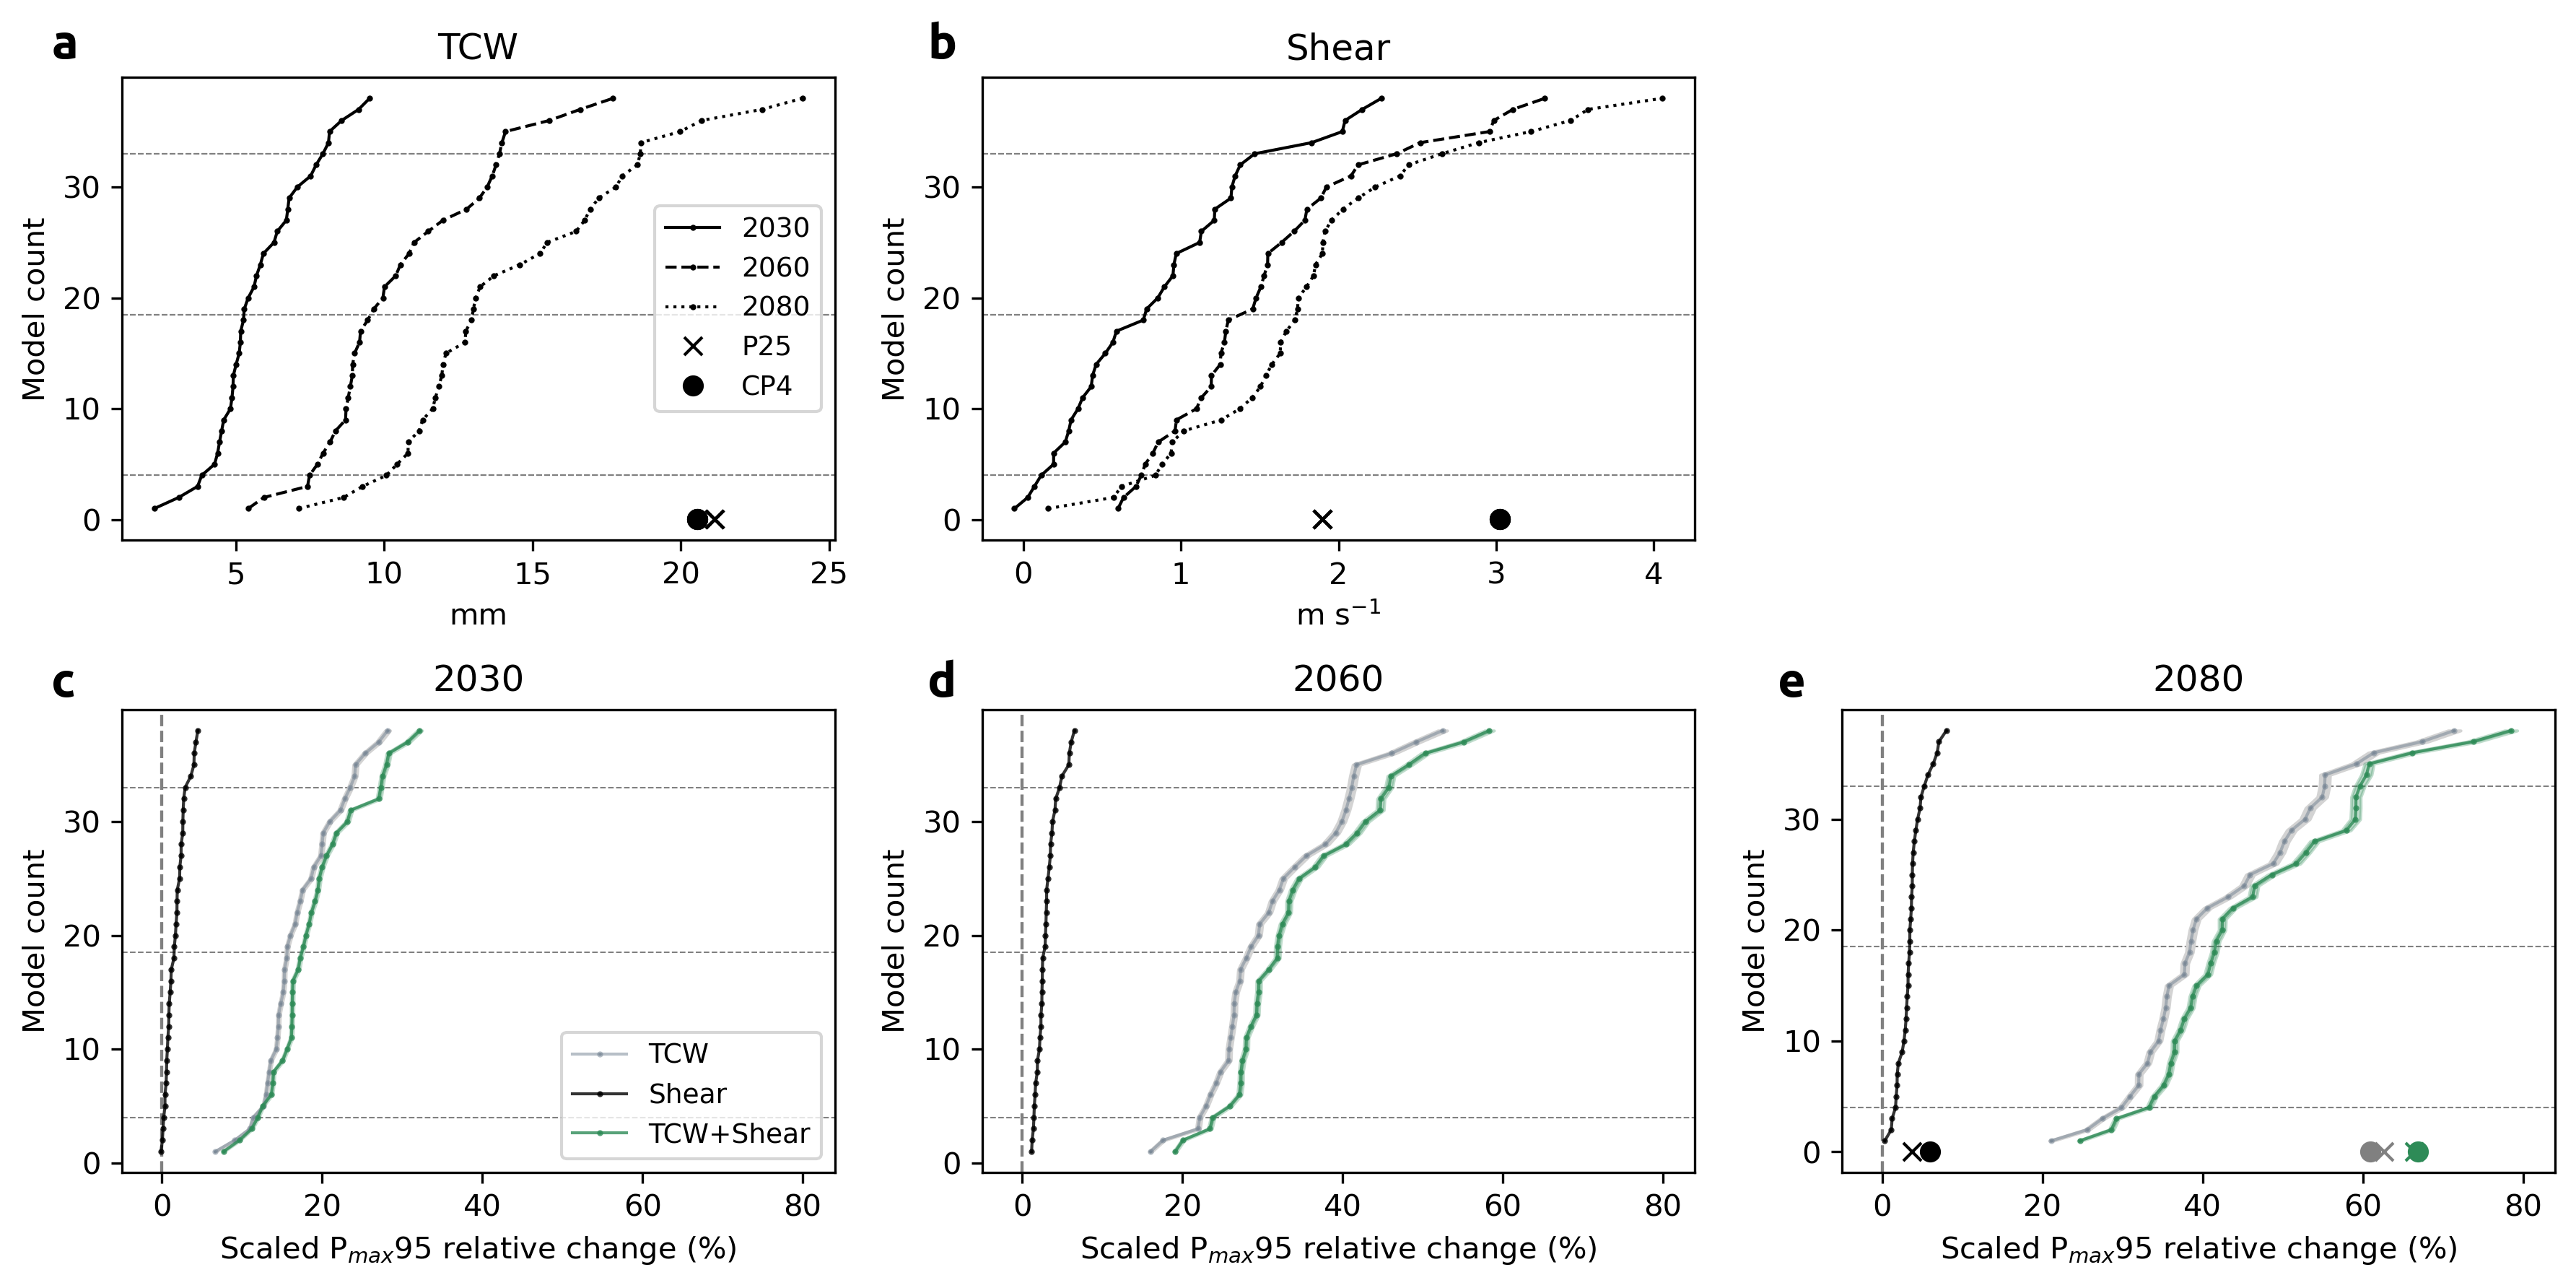

In [18]:
f = plt.figure(figsize=(12,6), dpi=300)
ax1 = f.add_subplot(2,3,1)
ax2 = f.add_subplot(2,3,2)

perc_dic = {}


linestyle = ['solid', 'dashed', 'dotted']
for ids, stry in enumerate(['2030', '2060', '2080']):
    

    ##########
    x = ((cmip_read[stry])['tcw_mean'])
    cumulative = np.sort(x)

    ax1.plot(cumulative, np.arange(len(cumulative))+1, label=stry, marker='o', markersize=1, color='k', linestyle=linestyle[ids], linewidth=1)

    #ax1.plot(x_grid, pdf, color='k', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
    ax1.set_title('TCW')
    ax1.set_xlabel('mm')  #kg m$^{-2}$
    ax1.set_ylabel('Model count')


    #ax1.axvline(0, linestyle='dashed', lw=1)

    x = (cmip_read[stry])['shear_mean']
    cumulative = np.sort(x)

    ax2.plot(cumulative, np.arange(len(cumulative))+1, label=stry, marker='o', markersize=1, color='k', linestyle=linestyle[ids], linewidth=1)
    
    ax2.set_title('Shear')
    ax2.set_xlabel('m s$^{-1}$')
    ax2.set_ylabel('Model count')
    
    if ids == 2:

        ax1.plot(cp25_tcwv_diff,0.03, color='k', marker='x', label='P25', linestyle='')
        ax1.plot(cp4_tcwv_diff,0.03, color='k', marker='o', label='CP4', linestyle='')

        ax2.plot(cp25_shear_diff,0.03, color='k', marker='x', label='P25', linestyle='')
        ax2.plot(cp4_shear_diff,0.03, color='k', marker='o', label='CP4', linestyle='')
    else:
        
        
        ax1.plot(cp25_tcwv_diff,0.03, color='k', marker='x', linestyle='')
        ax1.plot(cp4_tcwv_diff,0.03, color='k', marker='o', linestyle='')

        ax2.plot(cp25_shear_diff,0.03, color='k', marker='x',  linestyle='')
        ax2.plot(cp4_shear_diff,0.03, color='k', marker='o',  linestyle='')
        
    ax1.axhline(18.5, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax1.axhline(4, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax1.axhline(33, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    
    ax2.axhline(18.5, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax2.axhline(4, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax2.axhline(33, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    

    ax = f.add_subplot(2,3,ids+4)
    ##########
    ax.axhline(18.5, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax.axhline(4, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax.axhline(33, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    
    x = ((cmip_read[stry])['tcw_mean']) * tcabsfac  / mmPerPercent
    cumulative = np.sort(x)
    
    order = np.argsort(x)
    mnames = (cmip_read['2040']).index[order]
    
    error_low = (((cmip_read[stry])['tcw_mean']) * (tcabsfac-tcabserr)  / mmPerPercent)[order]
    error_high = (((cmip_read[stry])['tcw_mean']) * (tcabsfac+tcabserr)  / mmPerPercent)[order]
    
    error_lowr = (((cmip_read[stry])['tcw_mean']) * (tcwvfac-tcrelerr))[order]
    error_highr = (((cmip_read[stry])['tcw_mean']) * (tcwvfac+tcrelerr))[order]
    
    #ipdb.set_trace()
    
    perc_num = np.arange(len((cmip_read[stry])['tcw_mean']))
    perc = np.round(np.percentile(perc_num, [10,90]),0).astype(int)
    
    print('10,90 perc tcw model', mnames[perc[0]], mnames[perc[-1]])
    perc_dic[stry] = {'tcw': (mnames[perc[0]], mnames[perc[-1]])}

    ax.plot(cumulative, np.arange(len(cumulative))+1, color='slategrey', alpha=0.5, label='TCW', marker='o', markersize=1, zorder=99, linewidth=1)
    ax.fill_betweenx(np.arange(len(cumulative))+1, error_low, error_high, color='lightgrey', zorder=99)
#     ax.axvline(0, linestyle='dashed', lw=1, color='grey')
#     ax.axhline(18.5, linestyle='dashed', lw=1, color='grey')

    ###
    #shplot = hist2d.basic_1d_binning(cmip_sh_precip['2080'].values, np.arange(np.min(cmip_sh_precip['2080']), np.max(cmip_sh_precip['2080']),0.1))
    #ax.bar(shplot['xbins'], shplot['nb']/np.sum(shplot['nb']), color='k', label='Shear', width=0.1)
    ##----
    x = ((cmip_read[stry])['shear_mean']) * shearfac / mmPerPercent
    cumulative = np.sort(x)
    
    order = np.argsort(x)
    mnames = (cmip_read['2040']).index[order]
    
    perc_num = np.arange(len((cmip_read[stry])['tcw_mean']))
    perc = np.round(np.percentile(perc_num, [10,90]),0).astype(int)
    
    print(stry, '10,90 perc shear model', mnames[perc[0]], mnames[perc[-1]])
    (perc_dic[stry])['shear'] = ( mnames[perc[0]], mnames[perc[-1]])
    
    ax.plot(cumulative, np.arange(len(cumulative))+1, color='k', alpha=0.8, label='Shear', marker='o', markersize=1, zorder=99, linewidth=1)
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ###
    #stplot = hist2d.basic_1d_binning(cmip_shtc_precip[stry].values, np.arange(np.min(cmip_shtc_precip[stry]), np.max(cmip_shtc_precip[stry]),1))
    #ax.bar(stplot['xbins'], stplot['nb']/np.sum(stplot['nb']), color='seagreen', label='TCWV+Shear')
    ##----
    x = (((cmip_read[stry])['shear_mean']) * shearfac + ((cmip_read[stry])['tcw_mean']) * tcabsfac) / mmPerPercent
    cumulative = np.sort(x)
    
    order = np.argsort(x)
    mnames = (cmip_read['2040']).index[order]
    
    error_low = ((((cmip_read[stry])['shear_mean']) * shearfac + ((cmip_read[stry])['tcw_mean']) * (tcabsfac-tcabserr)) / mmPerPercent)[order]
    error_high = ((((cmip_read[stry])['shear_mean']) * shearfac + ((cmip_read[stry])['tcw_mean']) * (tcabsfac+tcabserr)) / mmPerPercent)[order]
    
    perc_num = np.arange(len((cmip_read[stry])['tcw_mean']))
    perc = np.round(np.percentile(perc_num, [10,90]),0).astype(int)
    
    print('10,90 perc shear+tcw model', mnames[perc[0]], mnames[perc[-1]], perc)
    (perc_dic[stry])['shear+tcw'] = ( mnames[perc[0]], mnames[perc[-1]])
    
    
    ax.plot(cumulative, np.arange(len(cumulative))+1, color='seagreen', alpha=0.8, label='TCW+Shear', marker='o', markersize=1, zorder=99, linewidth=1)
    ax.fill_betweenx(np.arange(len(cumulative))+1, error_low, error_high, color='seagreen', alpha=0.3, zorder=99)
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ##############
    if ids == 2:
        ax.plot(cp25_tcwv_diff * tcabsfac/ mmPerPercent,0.03, color='grey', marker='x')
        ax.plot(cp4_tcwv_diff * tcabsfac/ mmPerPercent,0.03, color='grey', marker='o')
        ax.plot(cp25_shear_diff* shearfac / mmPerPercent,0.03, color='k', marker='x')
        ax.plot(cp4_shear_diff* shearfac / mmPerPercent,0.03, color='k', marker='o')
        ax.plot((cp25_shear_diff * shearfac +  cp25_tcwv_diff * tcabsfac)/ mmPerPercent,0.03, color='seagreen', marker='x')
        ax.plot((cp4_shear_diff * shearfac +  cp4_tcwv_diff * tcabsfac)/ mmPerPercent,0.03, color='seagreen', marker='o')
   
    plt.xlabel('Scaled P$_{max}95$ relative change (%)')
    plt.ylabel('Model count')
    ax.set_xlim(-5,84)

    plt.title(stry)
    if ids == 0:
        plt.legend(loc='lower right', fontsize=9)  #facecolor='lightgrey'
ax1.legend(fontsize=9)
#ax2.legend()

#ipdb.set_trace()
plt.tight_layout()
text = ['a', 'b', 'c', 'd', 'e']
plt.annotate(text[0], xy=(0.02, 0.945), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.36, 0.945), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.02, 0.45), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.36, 0.45), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[4], xy=(0.69, 0.45), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)

plt.savefig(cnst.network_data + 'figs/ENDGAME/CMIP_driver_order_Sahel_inclCP4_rel_hourlyScaling.jpg')

In [19]:
perc_dic

{'2030': {'tcw': ('bcc-csm1-1-m', 'HadGEM2-ES'),
  'shear': ('CMCC-CESM', 'MIROC-ESM'),
  'shear+tcw': ('bcc-csm1-1-m', 'ACCESS1-0')},
 '2060': {'tcw': ('GFDL-ESM2M', 'IPSL-CM5A-MR'),
  'shear': ('CSIRO-Mk3-6-0', 'ACCESS1-0'),
  'shear+tcw': ('GFDL-ESM2M', 'HadGEM2-ES')},
 '2080': {'tcw': ('GISS-E2-R', 'CMCC-CMS'),
  'shear': ('FGOALS-g2', 'ACCESS1-0'),
  'shear+tcw': ('GISS-E2-R', 'BNU-ESM')}}

In [57]:
pkl.dump(perc_dic, open('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CMIPpercentiles_1090_Sahel_tcwShear.p', "wb"))

In [58]:
from scipy.stats import gaussian_kde

def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

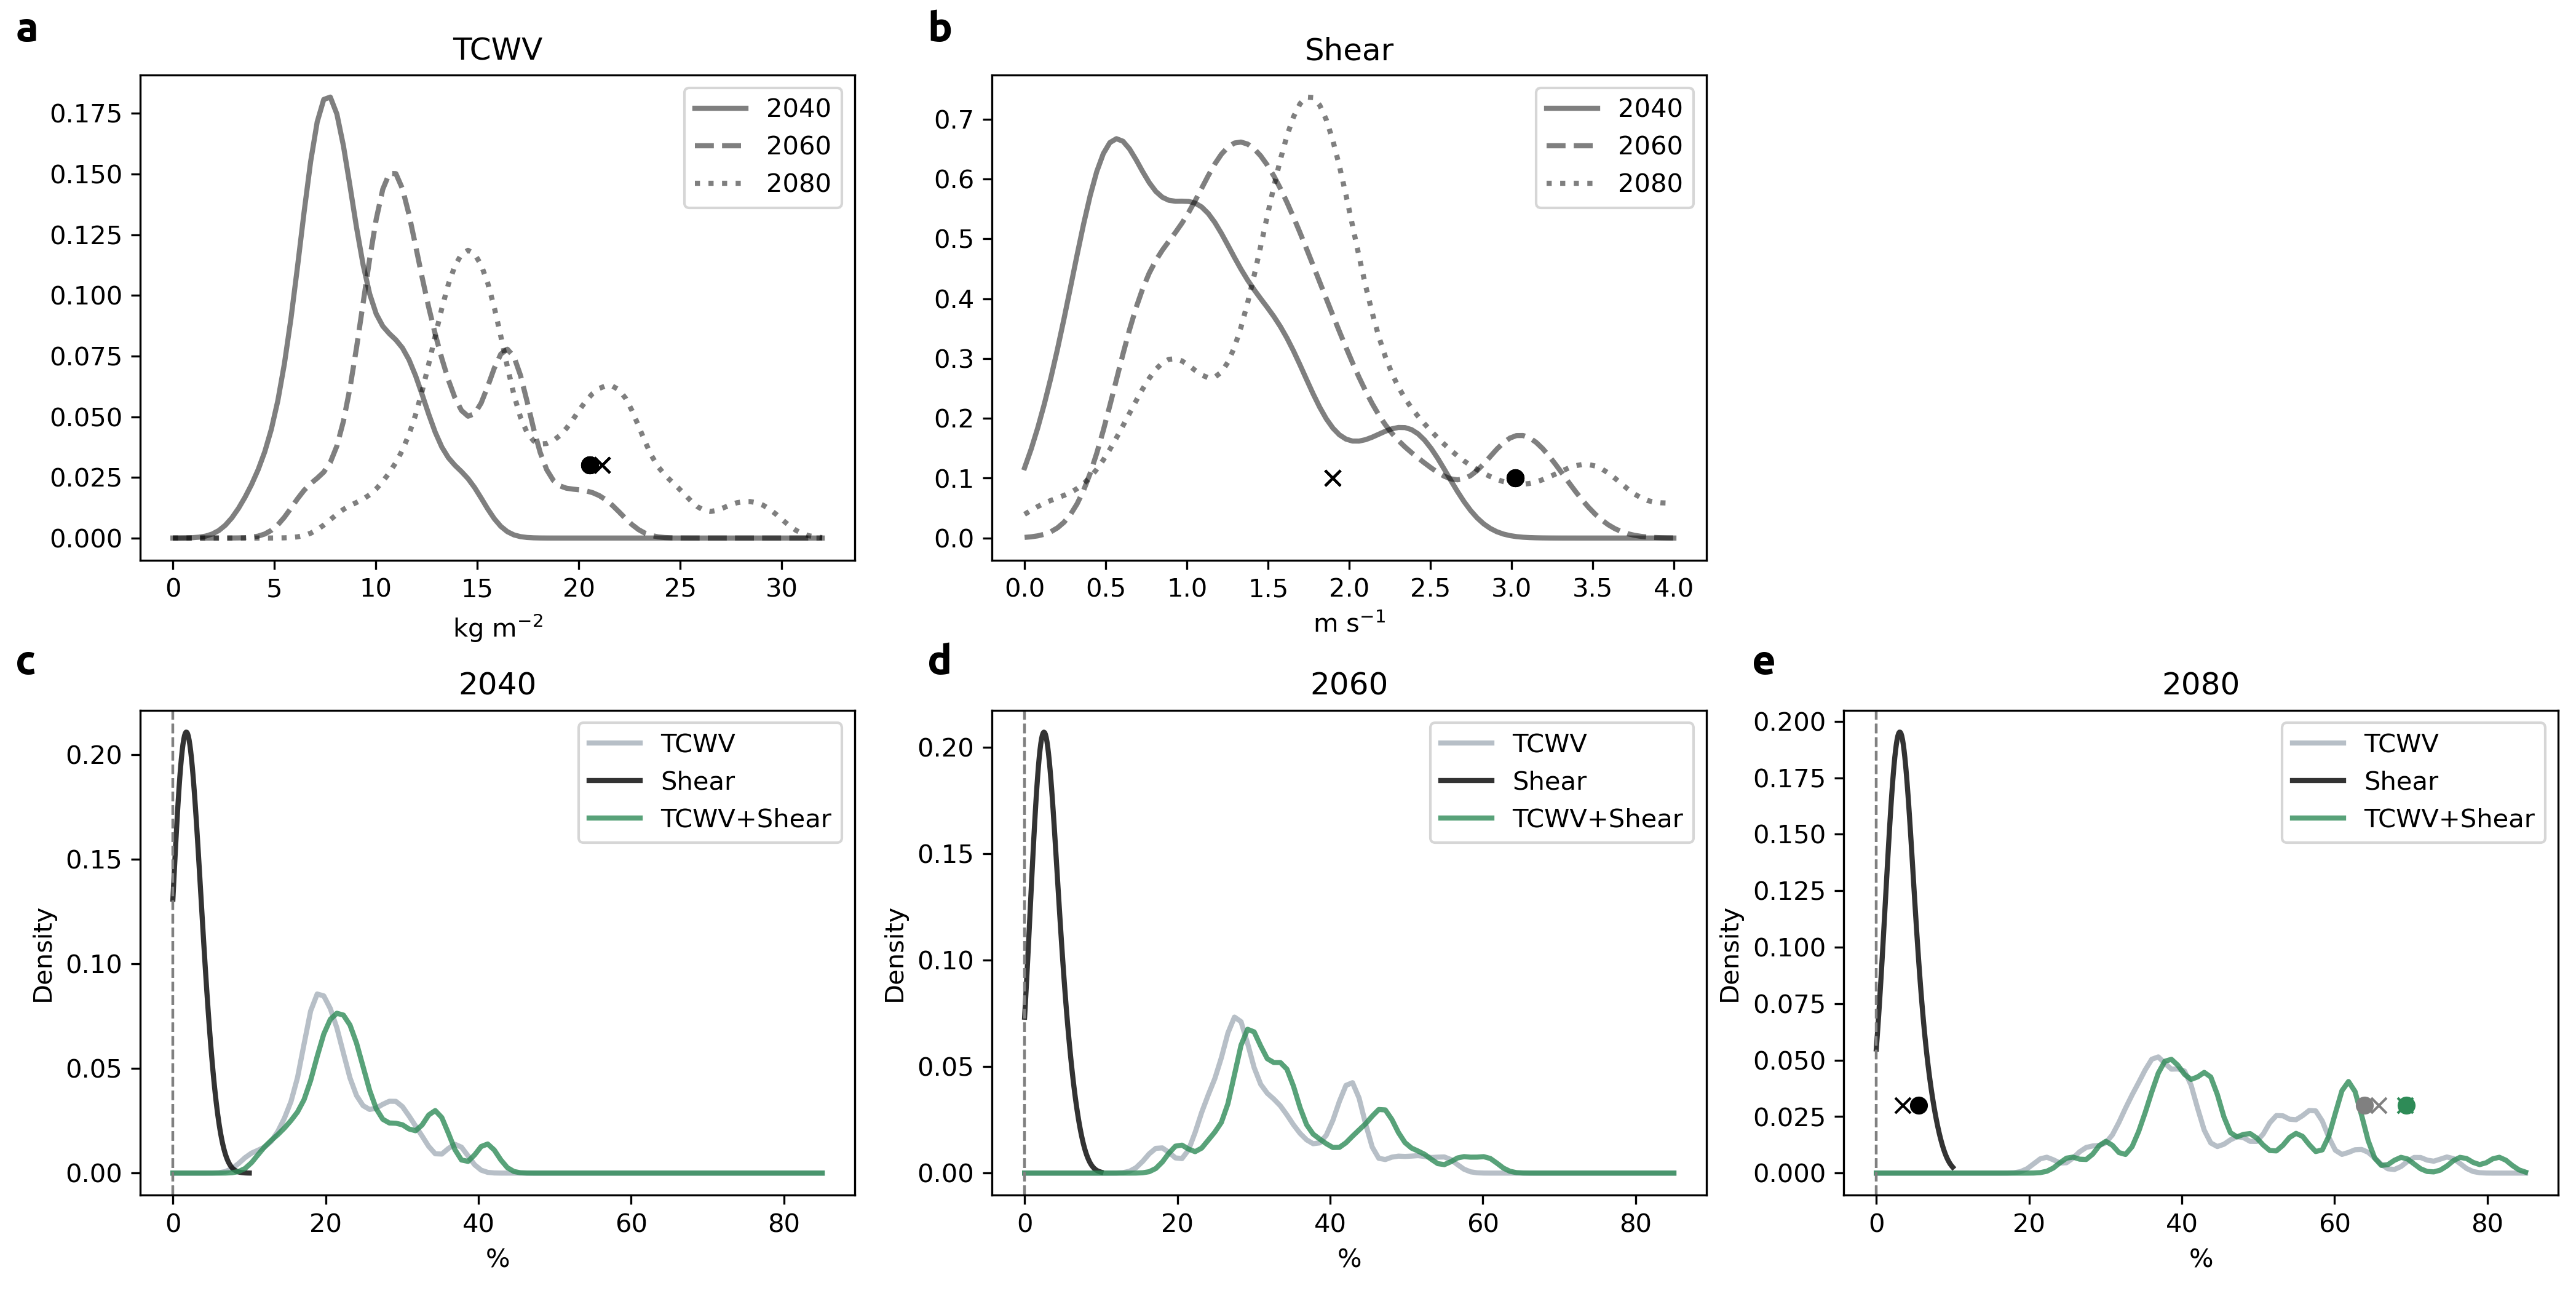

In [59]:

f = plt.figure(figsize=(14,7), dpi=300)
ax1 = f.add_subplot(2,3,1)
ax2 = f.add_subplot(2,3,2)


linestyle = ['solid', 'dashed', 'dotted']
for ids, stry in enumerate(['2040', '2060', '2080']):
    

    ##########

    x = ((cmip_read[stry])['tcw_mean']) * tcabsfac
    x_grid = np.linspace(0, 32, 100)
    pdf = kde_scipy(x, x_grid, bandwidth=1)
    ax1.plot(x_grid, pdf, color='k', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
    ax1.set_title('TCWV')
    ax1.set_xlabel('kg m$^{-2}$')
    #ax1.axvline(0, linestyle='dashed', lw=1)
    
#     if ids == 2:
#         x = cmip_sahel_tcw.values[np.isfinite(cmip_sahel_tcw.values)]
#         x_grid = np.linspace(0, 25, 100)
#         pdf = kde_scipy(x, x_grid, bandwidth=1)
#         ax1.plot(x_grid, pdf, color='b', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
#         ax1.set_title('TCWV')
#         ax1.set_xlabel('kg m$^{-2}$')
#         #ax1.axvline(0, linestyle='dashed', lw=1)
        
    
    
    #
    x = (cmip_read[stry])['shear_mean']
    x_grid = np.linspace(0, 4, 100)
    pdf = kde_scipy(x, x_grid, bandwidth=0.2)
    ax2.plot(x_grid, pdf, color='k', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
    ax2.set_title('Shear')
    ax2.set_xlabel('m s$^{-1}$')
    #plt.axvline(0, linestyle='dashed', lw=1)
    
#     if ids == 2:
        
#         x = cmip_sahel_sh.values[np.isfinite(cmip_sahel_sh.values)]
#         x_grid = np.linspace(-3, 1, 100)
#         pdf = kde_scipy(x, x_grid, bandwidth=0.2)
#         ax2.plot(x_grid, pdf, color='b', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
#         ax2.set_title('Shear')
#         ax2.set_xlabel('m s$^{-1}$')
#         #plt.axvline(0, linestyle='dashed', lw=1)
        
    ax1.plot(cp25_tcwv_diff,0.03, color='k', marker='x')
    ax1.plot(cp4_tcwv_diff,0.03, color='k', marker='o')
    #ax1.plot(cp4_sahel_tcw, 0.03, color='grey', marker='o')
    ax2.plot(cp25_shear_diff,0.1, color='k', marker='x')
    ax2.plot(cp4_shear_diff,0.1, color='k', marker='o')
    #ax2.plot(cp4_sahel_shear, 0.03, color='grey', marker='o')
        

    ax = f.add_subplot(2,3,ids+4)
    ##########
    #tcplot = hist2d.basic_1d_binning(cmip_tc_perc['2080'].values, np.arange(np.min(cmip_tc_perc['2080']), np.max(cmip_tc_perc['2080']),1))
    #ax.bar(tcplot['xbins'], tcplot['nb']/np.sum(tcplot['nb']), color='grey', label='TCWV')

    x = ((cmip_read[stry])['tcw_mean']) * tcabsfac  / mmPerPercent
    x_grid = np.linspace(0, 85, 100)
    pdf = kde_scipy(x, x_grid, bandwidth=1.5)
    ax.plot(x_grid, pdf, color='slategrey', alpha=0.5, lw=2, label='TCWV')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ###
    #shplot = hist2d.basic_1d_binning(cmip_sh_precip['2080'].values, np.arange(np.min(cmip_sh_precip['2080']), np.max(cmip_sh_precip['2080']),0.1))
    #ax.bar(shplot['xbins'], shplot['nb']/np.sum(shplot['nb']), color='k', label='Shear', width=0.1)
    ##----
    x = ((cmip_read[stry])['shear_mean']) * shearfac / mmPerPercent
    x_grid = np.linspace(0, 10, 100)
    pdf = kde_scipy(x, x_grid, bandwidth=1.5)
    ax.plot(x_grid, pdf, color='k', alpha=0.8, lw=2, label='Shear')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ###
    #stplot = hist2d.basic_1d_binning(cmip_shtc_precip[stry].values, np.arange(np.min(cmip_shtc_precip[stry]), np.max(cmip_shtc_precip[stry]),1))
    #ax.bar(stplot['xbins'], stplot['nb']/np.sum(stplot['nb']), color='seagreen', label='TCWV+Shear')
    ##----
    x = (((cmip_read[stry])['shear_mean']) * shearfac + ((cmip_read[stry])['tcw_mean']) * tcabsfac) / mmPerPercent
    x_grid = np.linspace(0, 85, 100)
    pdf = kde_scipy(x, x_grid, bandwidth=1.5)
    ax.plot(x_grid, pdf, color='seagreen', alpha=0.8, lw=2,  label='TCWV+Shear')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')
    ##############
#     if ids == 2:
#         ax.plot(cp4_precip.loc['tcw', 'R25DELTA'],0.01, color='grey', marker='x')
#         ax.plot(cp4_precip.loc['tcw', 'CP4DELTA'],0.01, color='grey', marker='o')
#         ax.plot(cp4_precip.loc['shear', 'R25DELTA'],0.01, color='k', marker='x')
#         ax.plot(cp4_precip.loc['shear', 'CP4DELTA'],0.01, color='k', marker='o')
#         ax.plot(cp4_precip.loc['tcw', 'R25DELTA']+cp4_precip.loc['shear', 'R25DELTA'],0.01, color='seagreen', marker='x')
#         ax.plot(cp4_precip.loc['tcw', 'CP4DELTA']+cp4_precip.loc['shear', 'CP4DELTA'],0.01, color='seagreen', marker='o')
        
    if ids == 2:
        ax.plot(cp25_tcwv_diff * tcabsfac/ mmPerPercent,0.03, color='grey', marker='x')
        ax.plot(cp4_tcwv_diff * tcabsfac/ mmPerPercent,0.03, color='grey', marker='o')
        ax.plot(cp25_shear_diff* shearfac / mmPerPercent,0.03, color='k', marker='x')
        ax.plot(cp4_shear_diff* shearfac / mmPerPercent,0.03, color='k', marker='o')
        ax.plot((cp25_shear_diff * shearfac +  cp25_tcwv_diff * tcabsfac)/ mmPerPercent,0.03, color='seagreen', marker='x')
        ax.plot((cp4_shear_diff * shearfac +  cp4_tcwv_diff * tcabsfac)/ mmPerPercent,0.03, color='seagreen', marker='o')

    plt.xlabel('%')
    plt.ylabel('Density')

    plt.title(stry)

    plt.legend()
ax1.legend()
ax2.legend()
plt.tight_layout()

text = ['a', 'b', 'c', 'd', 'e']
plt.annotate(text[0], xy=(0.006, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.36, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.006, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.36, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[4], xy=(0.68, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)

plt.savefig(cnst.network_data + 'figs/ENDGAME/CMIP_driver_PDF_Sahelonly.png')

NameError: name 'cmip_tc_diff' is not defined

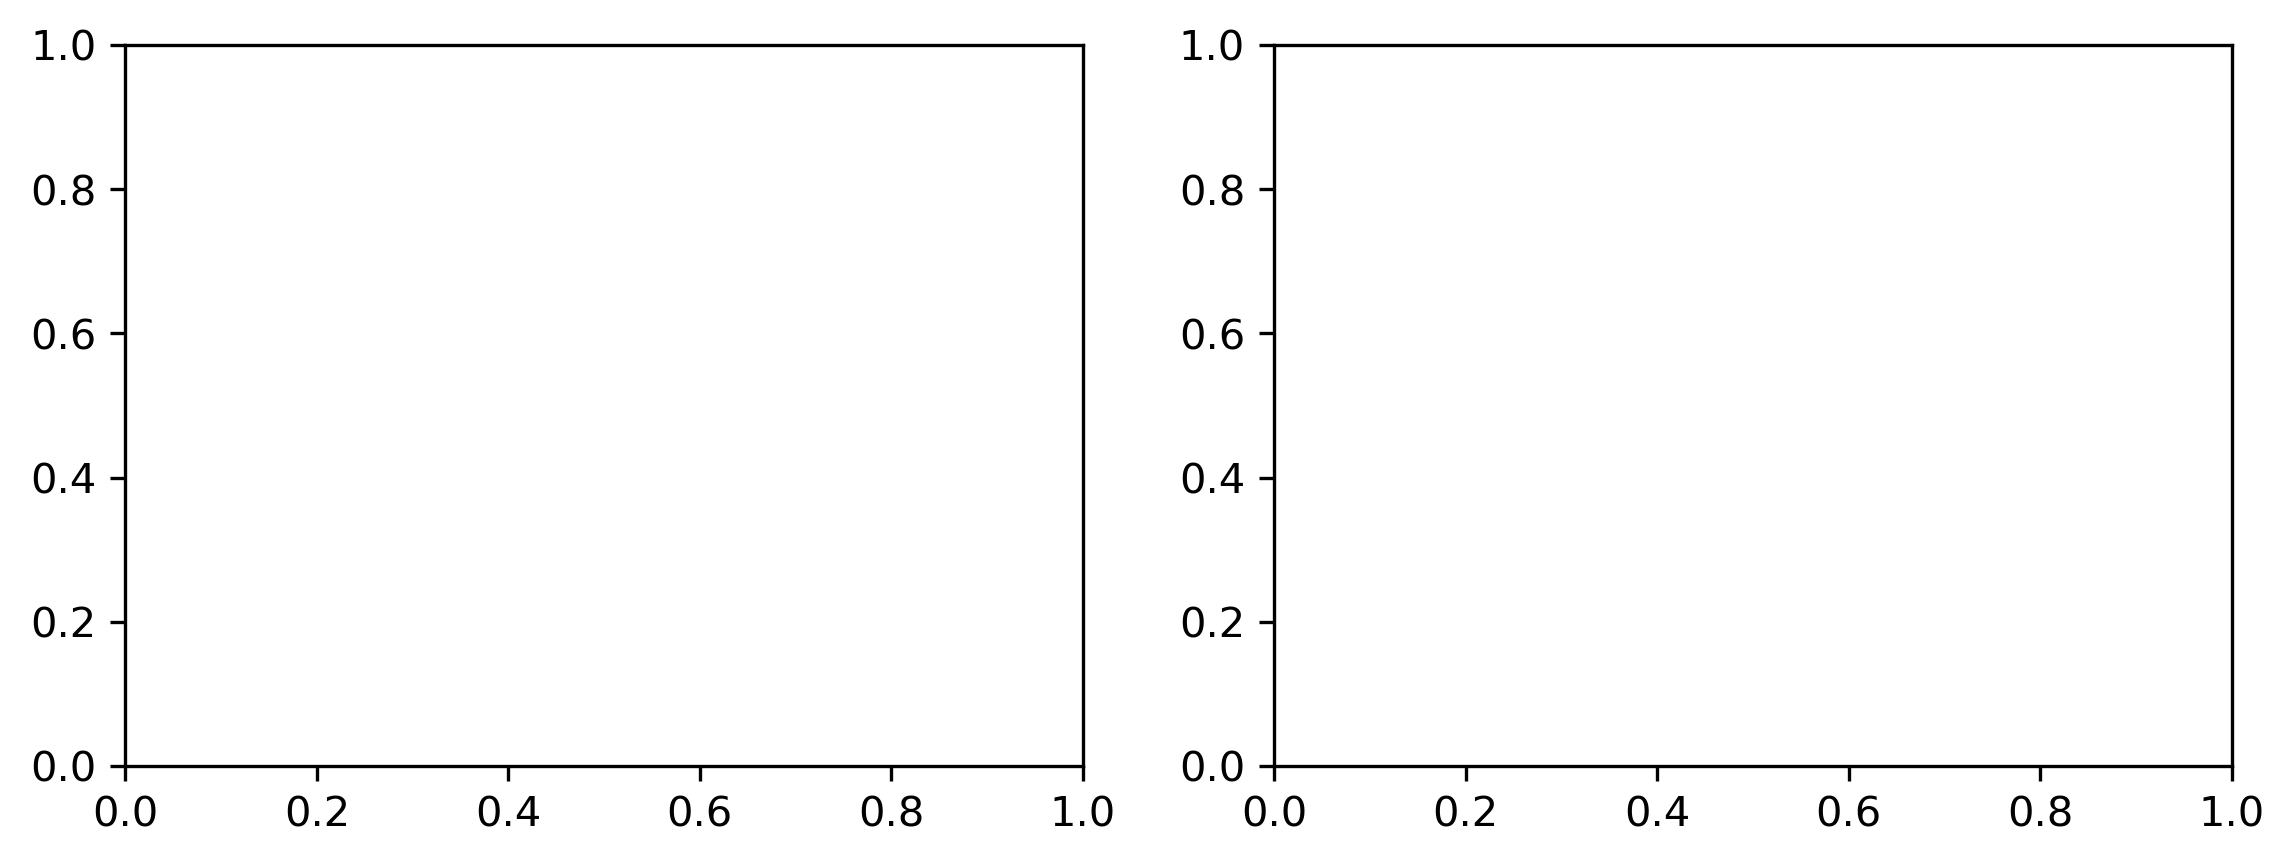

In [60]:
f = plt.figure(figsize=(14,7), dpi=300)
ax1 = f.add_subplot(2,3,1)
ax2 = f.add_subplot(2,3,2)

mk=3
linestyle = ['solid', 'dashed', 'dotted']
for ids, stry in enumerate(['2040', '2060', '2080']):
    

    ##########
    x = cmip_tc_diff[stry].values[np.isfinite(cmip_tc_diff[stry].values)]
    cumulative = np.sort(x)

    ax1.plot(cumulative, np.arange(len(cumulative))+1, label=stry, marker='o', markersize=mk, color='k', linestyle=linestyle[ids])
    #ax1.plot(x_grid, pdf, color='k', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
    ax1.set_title('TCWV')
    ax1.set_xlabel('kg m$^{-2}$')
    ax1.set_ylabel('Model number')

    ax1.plot(cp4_diff.loc['tcw', 'R25DELTA'],0.03, color='k', marker='x')
    ax1.plot(cp4_diff.loc['tcw', 'CP4DELTA'],0.03, color='k', marker='o')
    ax2.plot(cp4_diff.loc['shear', 'R25DELTA'],0.03, color='k', marker='x')
    ax2.plot(cp4_diff.loc['shear', 'CP4DELTA'],0.03, color='k', marker='o')

    #ax1.axvline(0, linestyle='dashed', lw=1)
    
    
    #
    x = cmip_sh_diff[stry].values[np.isfinite(cmip_sh_diff[stry].values)]
    cumulative = np.sort(x)

    ax2.plot(cumulative, np.arange(len(cumulative))+1, label=stry, marker='o', markersize=mk, color='k', linestyle=linestyle[ids])
    ax2.set_title('Shear')
    ax2.set_xlabel('m s$^{-1}$')
    ax2.set_ylabel('Model number')
    #plt.axvline(0, linestyle='dashed', lw=1)

    ax = f.add_subplot(2,3,ids+4)
    ##########
    x = cmip_tc_perc[stry].values[np.isfinite(cmip_tc_perc[stry].values)]
    cumulative = np.sort(x)

    ax.plot(cumulative, np.arange(len(cumulative))+1, color='slategrey', alpha=0.5, lw=2, label='TCWV', marker='o', markersize=mk, linestyle='solid')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ###
    #shplot = hist2d.basic_1d_binning(cmip_sh_precip['2080'].values, np.arange(np.min(cmip_sh_precip['2080']), np.max(cmip_sh_precip['2080']),0.1))
    #ax.bar(shplot['xbins'], shplot['nb']/np.sum(shplot['nb']), color='k', label='Shear', width=0.1)
    ##----
    x = cmip_sh_perc[stry].values[np.isfinite(cmip_sh_perc[stry].values)]
    cumulative = np.sort(x)
    ax.plot(cumulative, np.arange(len(cumulative))+1, color='k', alpha=0.8, lw=2, label='Shear', marker='o', markersize=mk, linestyle='solid')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ###
    #stplot = hist2d.basic_1d_binning(cmip_shtc_precip[stry].values, np.arange(np.min(cmip_shtc_precip[stry]), np.max(cmip_shtc_precip[stry]),1))
    #ax.bar(stplot['xbins'], stplot['nb']/np.sum(stplot['nb']), color='seagreen', label='TCWV+Shear')
    ##----
    x = cmip_shtc_precip[stry].values[np.isfinite(cmip_shtc_precip[stry].values)]
    cumulative = np.sort(x)
    
    ax.plot(cumulative, np.arange(len(cumulative))+1, color='seagreen', alpha=0.8, lw=2,  label='TCWV+Shear', marker='o', markersize=mk, linestyle='solid')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')
    ##############
    if ids == 2:
        ax.plot(cp4_precip.loc['tcw', 'R25DELTA'],0.03, color='grey', marker='x')
        ax.plot(cp4_precip.loc['tcw', 'CP4DELTA'],0.03, color='grey', marker='o')
        ax.plot(cp4_precip.loc['shear', 'R25DELTA'],0.03, color='k', marker='x')
        ax.plot(cp4_precip.loc['shear', 'CP4DELTA'],0.03, color='k', marker='o')
        ax.plot(cp4_precip.loc['tcw', 'R25DELTA']+cp4_precip.loc['shear', 'R25DELTA'],0.03, color='seagreen', marker='x')
        ax.plot(cp4_precip.loc['tcw', 'CP4DELTA']+cp4_precip.loc['shear', 'CP4DELTA'],0.03, color='seagreen', marker='o')
   
    plt.xlabel('%')
    plt.ylabel('Model number')

    plt.title(stry)
    if ids == 0:
        plt.legend()
ax1.legend()
#ax2.legend()

#ipdb.set_trace()

text = ['a', 'b', 'c', 'd', 'e']
plt.annotate(text[0], xy=(0.006, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.36, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.006, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.36, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[4], xy=(0.68, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/ENDGAME/CMIP_driver_marker+uncertainty.png')